In [428]:
import glob
import csv
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Task 1-2

Dividing the loaded data set into training, test and validation samples

In [430]:

import os
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split

train_path = 'train_sample'
test_path = 'test_sample'
val_path = 'val_sample'

df = pd.read_csv('annotation1.csv', sep=',', header=None)
df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'abs_way', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)

for path in [train_path, test_path, val_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

def load_image(df, path, i):
    image_path = os.path.abspath(os.path.join(*df.abs_way[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

for i in range(800):
    load_image(df, train_path, i)
for i in range(1000, 1800):
    load_image(df, train_path, i)
for i in range(800, 900):
    load_image(df, test_path, i)
for i in range(1800, 1900):
    load_image(df, test_path, i)
for i in range(900, 1000):
    load_image(df, val_path, i)
for i in range(1900, 1999):
    load_image(df, val_path, i)

train_sample = glob.glob(os.path.join(train_path, '*.jpg'))
test_sample = glob.glob(os.path.join(test_path, '*.jpg'))

train_sample, val_sample = train_test_split(train_sample, test_size=0.1)


      index                abs_way img_class
0         1  dataset/dogs/0071.jpg      dogs
1         2  dataset/dogs/0717.jpg      dogs
2         3  dataset/dogs/0703.jpg      dogs
3         4  dataset/dogs/0065.jpg      dogs
4         5  dataset/dogs/0059.jpg      dogs
...     ...                    ...       ...
1995   1996  dataset/cats/0040.jpg      cats
1996   1997  dataset/cats/0726.jpg      cats
1997   1998  dataset/cats/0732.jpg      cats
1998   1999  dataset/cats/0054.jpg      cats
1999   2000  dataset/cats/0068.jpg      cats

[2000 rows x 3 columns]


Check datasets

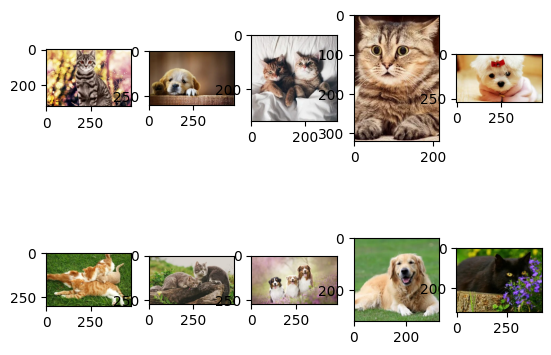

In [431]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_sample[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

# Task 4

A dataset class that will store the loaded and converted images and class labels

In [432]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'cats':
            label=1
        elif label == 'dogs':
            label=0
            
        return img_transformed,label

Data preprocessing pipeline

In [433]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])



In [434]:
train_data = dataset(train_sample, transform=train_transforms)
test_data = dataset(test_sample, transform=test_transforms)
val_data = dataset(val_sample, transform=val_transforms)

data checking

In [435]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.7333, 0.7333, 0.7216,  ..., 0.5137, 0.5098, 0.5098],
         [0.7333, 0.7333, 0.7216,  ..., 0.5137, 0.5098, 0.5098],
         [0.7373, 0.7373, 0.7255,  ..., 0.5098, 0.5059, 0.5059],
         ...,
         [0.5922, 0.5922, 0.6235,  ..., 0.7843, 0.7725, 0.7725],
         [0.5922, 0.5922, 0.6235,  ..., 0.7804, 0.7647, 0.7647],
         [0.5922, 0.5922, 0.6235,  ..., 0.7804, 0.7647, 0.7647]],

        [[0.7098, 0.7098, 0.7020,  ..., 0.5765, 0.5725, 0.5725],
         [0.7098, 0.7098, 0.7020,  ..., 0.5765, 0.5725, 0.5725],
         [0.7137, 0.7137, 0.7020,  ..., 0.5725, 0.5686, 0.5686],
         ...,
         [0.6000, 0.6000, 0.6275,  ..., 0.7843, 0.7765, 0.7765],
         [0.6000, 0.6000, 0.6314,  ..., 0.7804, 0.7686, 0.7686],
         [0.6000, 0.6000, 0.6314,  ..., 0.7804, 0.7686, 0.7686]],

        [[0.6039, 0.6039, 0.5843,  ..., 0.2941, 0.2941, 0.2941],
         [0.6039, 0.6039, 0.5843,  ..., 0.2941, 0.2941, 0.2941],
         [0.6078, 0.6078, 0.5882,  ..., 0.2902, 0.2902, 0

# Task 3


setting values ​​for the number of images processed at a time and the learning speed

In [436]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method

loading a dataset into dataloader

In [437]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True )

test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                         batch_size=batch_size, 
                                         shuffle=False)

verification of sets

In [438]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1440 15
160 2


torch.Size([3, 224, 224])

Convolutional neural network model for solving the classification problem

In [439]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.Flatten()(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return torch.nn.Sigmoid()(out)

In [446]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (re

In [441]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1440 15
160 2


torch.Size([3, 224, 224])

# Task 5


transferring data to one place

In [442]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)

setting processing parameters - optimization - updating data and error criterion by which the network will be trained

In [443]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.BCELoss()

Neural network training cycle

In [444]:
accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

def train_loop(train_loader, val_loader):
    epochs = 10
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())
        
        model.eval()
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label.unsqueeze(dim=1).to(torch.float))
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        val_accuracy_values.append(epoch_val_accuracy.item())
        val_loss_values.append(epoch_val_loss.item())
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        print('\n')

In [445]:
train_loop(train_loader, val_loader)

Epoch : 1, train accuracy : 0.5069999694824219, train loss : 0.6762501001358032
Epoch : 1, val_accuracy : 0.4749999940395355, val_loss : 0.6838197708129883


Epoch : 2, train accuracy : 0.5010000467300415, train loss : 0.6796082258224487
Epoch : 2, val_accuracy : 0.4749999940395355, val_loss : 0.6985294222831726


Epoch : 3, train accuracy : 0.5049999952316284, train loss : 0.6665446162223816
Epoch : 3, val_accuracy : 0.4749999940395355, val_loss : 0.6674582362174988


Epoch : 4, train accuracy : 0.4989999830722809, train loss : 0.65267014503479
Epoch : 4, val_accuracy : 0.4749999940395355, val_loss : 0.6473501324653625


Epoch : 5, train accuracy : 0.502000093460083, train loss : 0.6449204087257385
Epoch : 5, val_accuracy : 0.4749999940395355, val_loss : 0.6959730386734009


Epoch : 6, train accuracy : 0.5099999904632568, train loss : 0.6475402116775513
Epoch : 6, val_accuracy : 0.4749999940395355, val_loss : 0.6497796773910522


Epoch : 7, train accuracy : 0.5009999871253967, train l

# Task 6


training set graph

In [447]:
def show_results(acc, loss):
    plt.figure(figsize=(15, 5))
    plt.plot(range(10), acc, color="green")
    plt.legend(["Accuracy"])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(range(10), loss, color="blue")
    plt.legend(["Loss"])
    plt.show() 
    
    print(acc, '\n',loss)

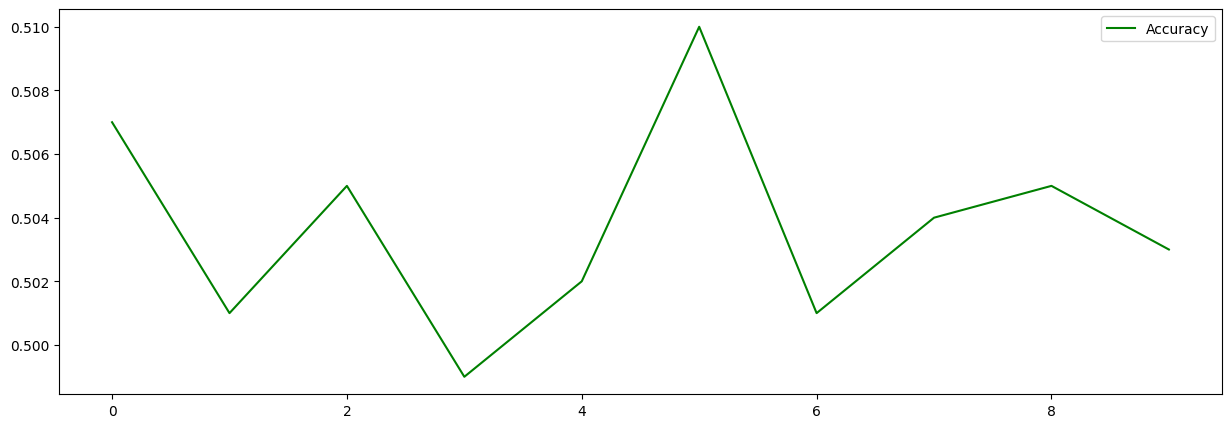

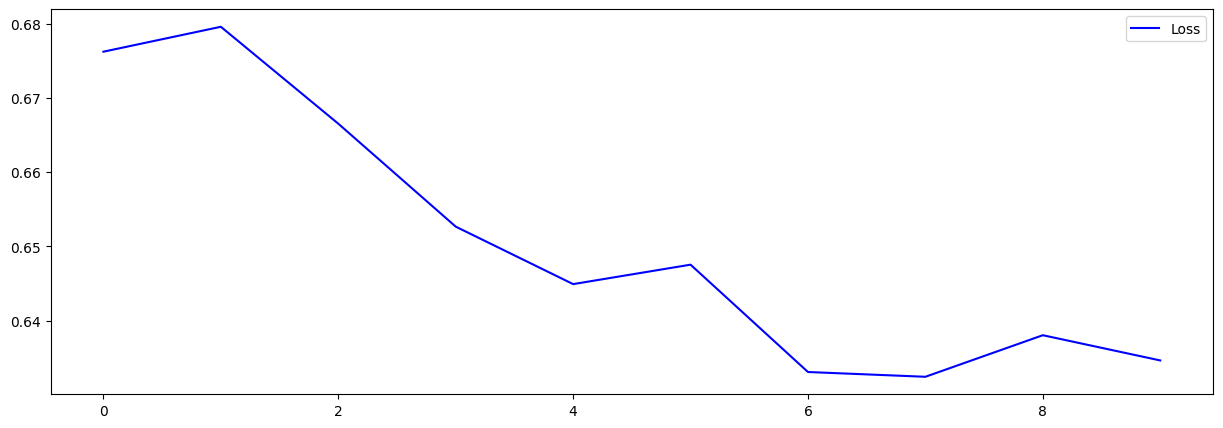

[0.5069999694824219, 0.5010000467300415, 0.5049999952316284, 0.4989999830722809, 0.502000093460083, 0.5099999904632568, 0.5009999871253967, 0.5040000081062317, 0.5049999952316284, 0.503000020980835] 
 [0.6762501001358032, 0.6796082258224487, 0.6665446162223816, 0.65267014503479, 0.6449204087257385, 0.6475402116775513, 0.6330714225769043, 0.6324291229248047, 0.6380324959754944, 0.6346304416656494]


In [448]:
show_results(accuracy_values, loss_values)

validation sample plot

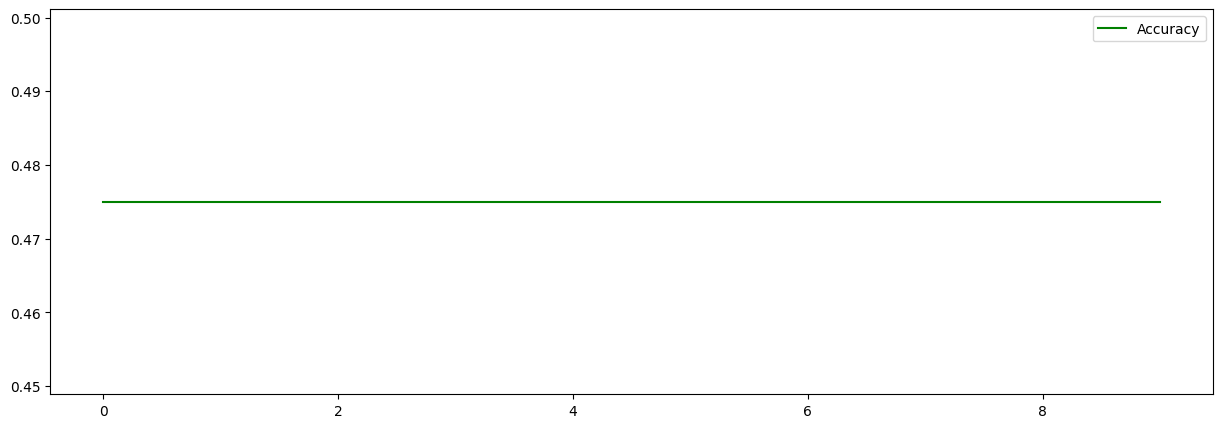

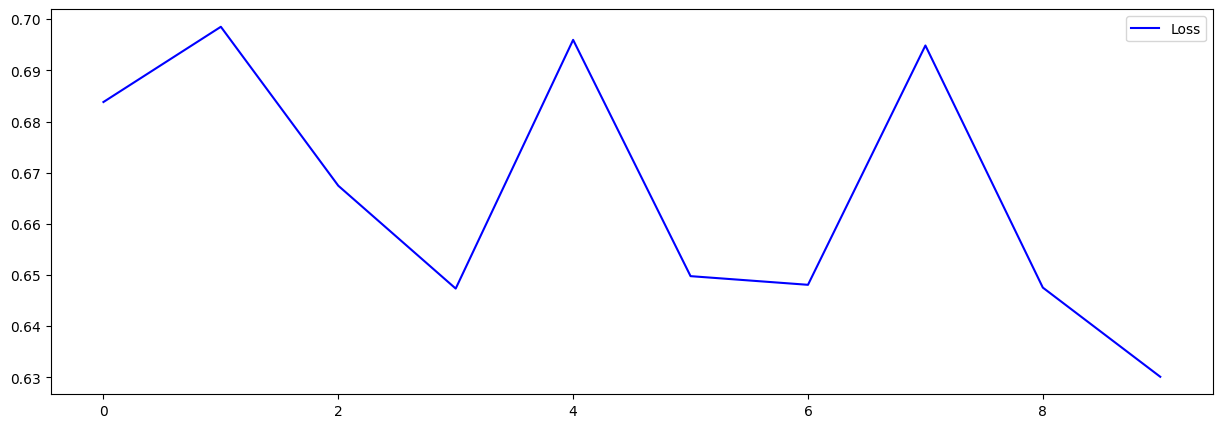

[0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355, 0.4749999940395355] 
 [0.6838197708129883, 0.6985294222831726, 0.6674582362174988, 0.6473501324653625, 0.6959730386734009, 0.6497796773910522, 0.6480869054794312, 0.6948721408843994, 0.6475417613983154, 0.6301081776618958]


In [451]:
show_results(val_accuracy_values, val_loss_values)


# plt.figure(figsize=(15, 5))
# plt.plot(range(10), val_accuracy_values, color="red")
# plt.legend(["Accuracy_val"])
# plt.show()

# plt.figure(figsize=(15, 5))
# plt.plot(range(10),val_loss_values, color="gray")
# plt.legend(["Loss_val"])
# plt.show()

# Train_loop_1

Epoch : 1, train accuracy : 0.5017242431640625, train loss : 0.6810283660888672
Epoch : 1, val_accuracy : 0.48500001430511475, val_loss : 0.6786431074142456


Epoch : 2, train accuracy : 0.5015518069267273, train loss : 0.6748600602149963
Epoch : 2, val_accuracy : 0.48500001430511475, val_loss : 0.6633859276771545


Epoch : 3, train accuracy : 0.5015518069267273, train loss : 0.6743626594543457
Epoch : 3, val_accuracy : 0.48500001430511475, val_loss : 0.6669832468032837


Epoch : 4, train accuracy : 0.502586305141449, train loss : 0.6620641350746155
Epoch : 4, val_accuracy : 0.48500001430511475, val_loss : 0.6316221952438354


Epoch : 5, train accuracy : 0.5020690560340881, train loss : 0.65318763256073
Epoch : 5, val_accuracy : 0.48500001430511475, val_loss : 0.6697321534156799


Epoch : 6, train accuracy : 0.5025863647460938, train loss : 0.6397878527641296
Epoch : 6, val_accuracy : 0.48500001430511475, val_loss : 0.625845730304718


Epoch : 7, train accuracy : 0.5029311180114746, tr

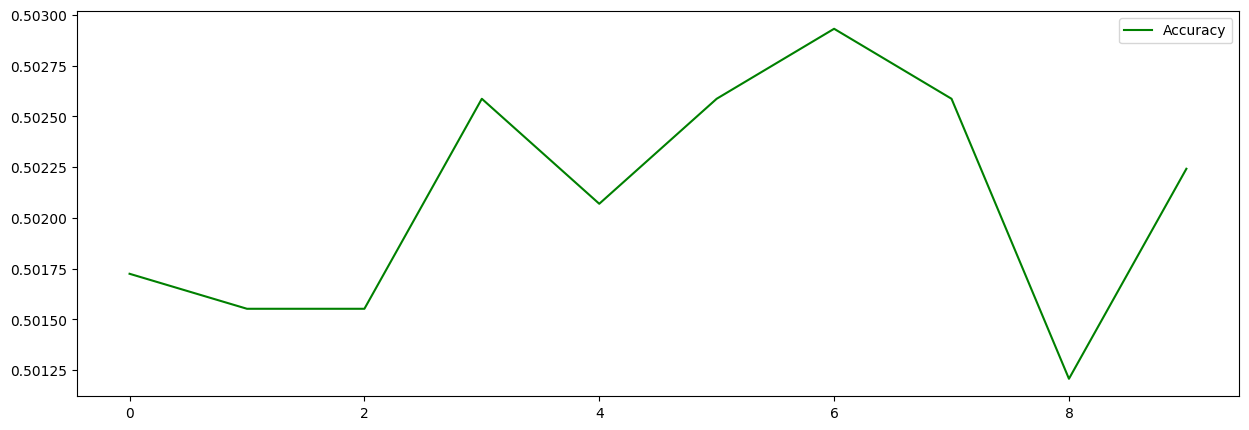

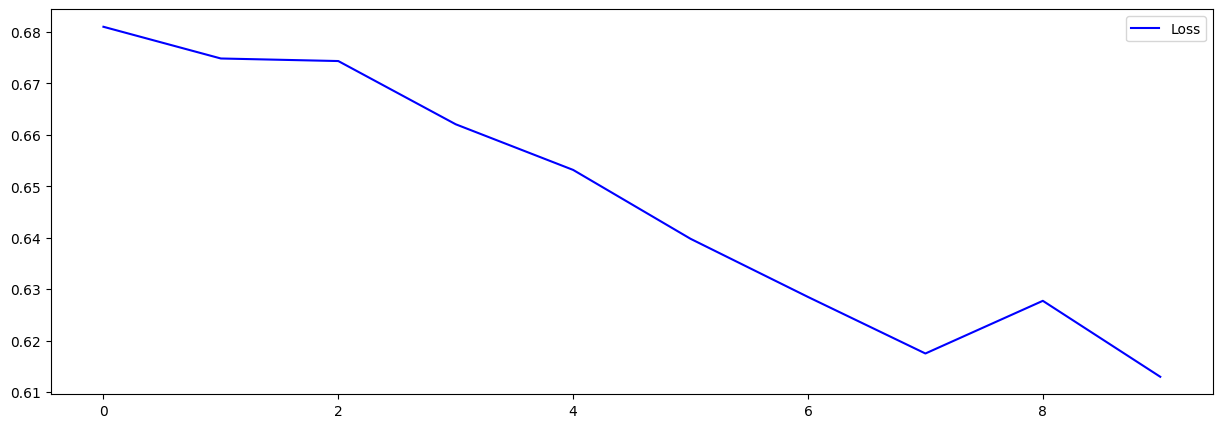

[0.5017242431640625, 0.5015518069267273, 0.5015518069267273, 0.502586305141449, 0.5020690560340881, 0.5025863647460938, 0.5029311180114746, 0.502586305141449, 0.5012069940567017, 0.5022414922714233] 
 [0.6810283660888672, 0.6748600602149963, 0.6743626594543457, 0.6620641350746155, 0.65318763256073, 0.6397878527641296, 0.6284791231155396, 0.617479145526886, 0.6277243494987488, 0.6129503846168518]


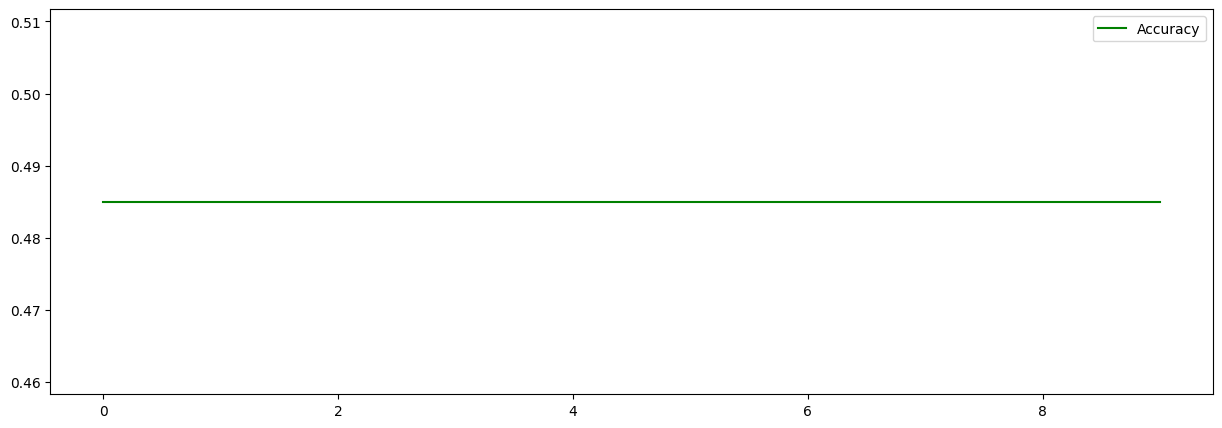

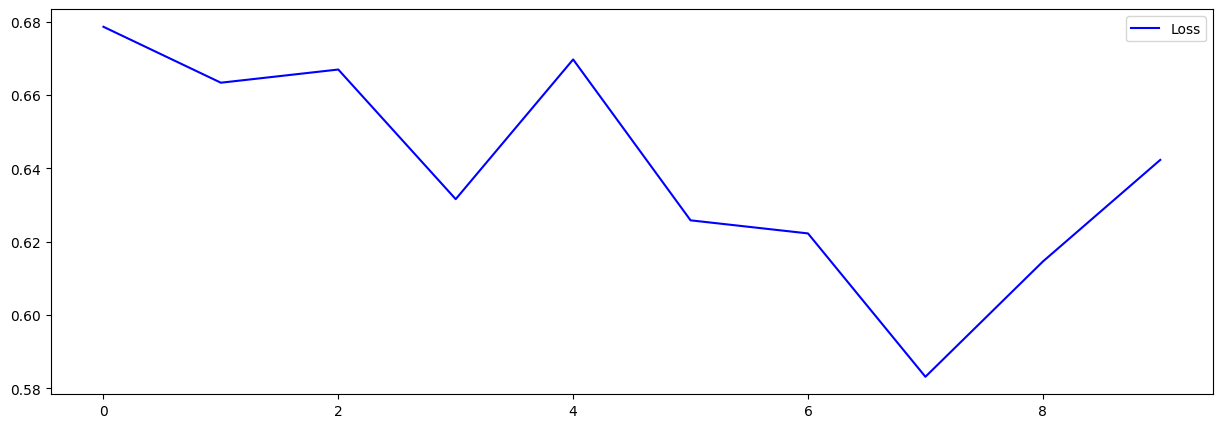

[0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475] 
 [0.6786431074142456, 0.6633859276771545, 0.6669832468032837, 0.6316221952438354, 0.6697321534156799, 0.625845730304718, 0.6222765445709229, 0.5831706523895264, 0.614597737789154, 0.6423329710960388]


In [452]:
lear = 0.001
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_2

Epoch : 1, train accuracy : 0.5068750381469727, train loss : 0.5930843949317932
Epoch : 1, val_accuracy : 0.48124998807907104, val_loss : 0.6120501756668091


Epoch : 2, train accuracy : 0.5118749737739563, train loss : 0.6024279594421387
Epoch : 2, val_accuracy : 0.48124998807907104, val_loss : 0.6191529631614685


Epoch : 3, train accuracy : 0.49937495589256287, train loss : 0.588821291923523
Epoch : 3, val_accuracy : 0.48124998807907104, val_loss : 0.5720958113670349


Epoch : 4, train accuracy : 0.5018750429153442, train loss : 0.5908746719360352
Epoch : 4, val_accuracy : 0.48124998807907104, val_loss : 0.5745950937271118


Epoch : 5, train accuracy : 0.5068749785423279, train loss : 0.5782201290130615
Epoch : 5, val_accuracy : 0.48124998807907104, val_loss : 0.5877291560173035


Epoch : 6, train accuracy : 0.5068750381469727, train loss : 0.585815966129303
Epoch : 6, val_accuracy : 0.48124998807907104, val_loss : 0.6071902513504028


Epoch : 7, train accuracy : 0.4918749928474426,

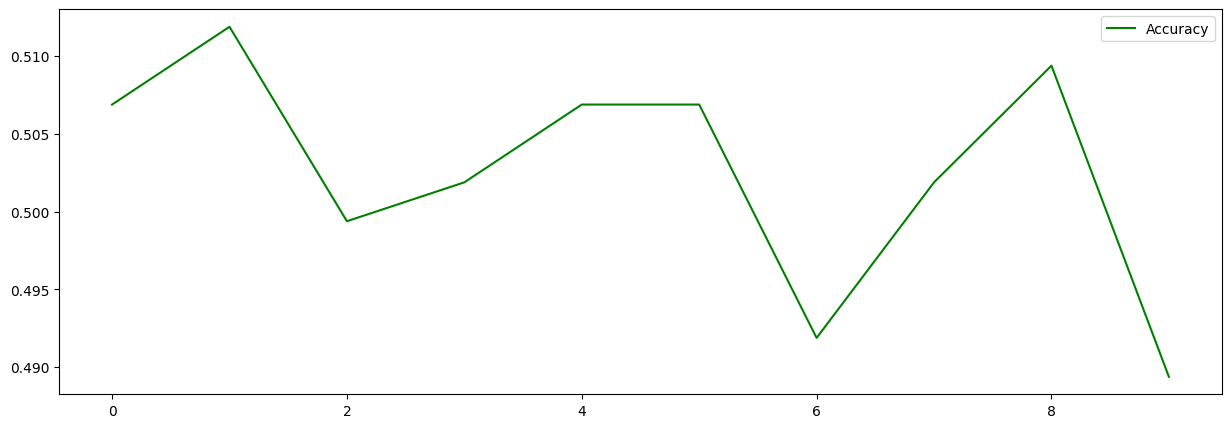

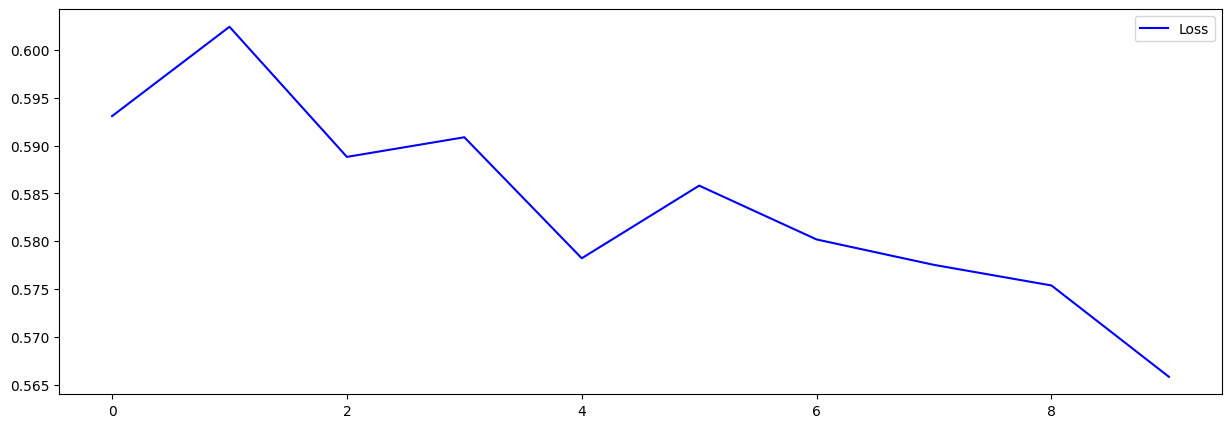

[0.5068750381469727, 0.5118749737739563, 0.49937495589256287, 0.5018750429153442, 0.5068749785423279, 0.5068750381469727, 0.4918749928474426, 0.5018749833106995, 0.5093750357627869, 0.4893750250339508] 
 [0.5930843949317932, 0.6024279594421387, 0.588821291923523, 0.5908746719360352, 0.5782201290130615, 0.585815966129303, 0.5801860690116882, 0.5775278806686401, 0.5753757357597351, 0.5658272504806519]


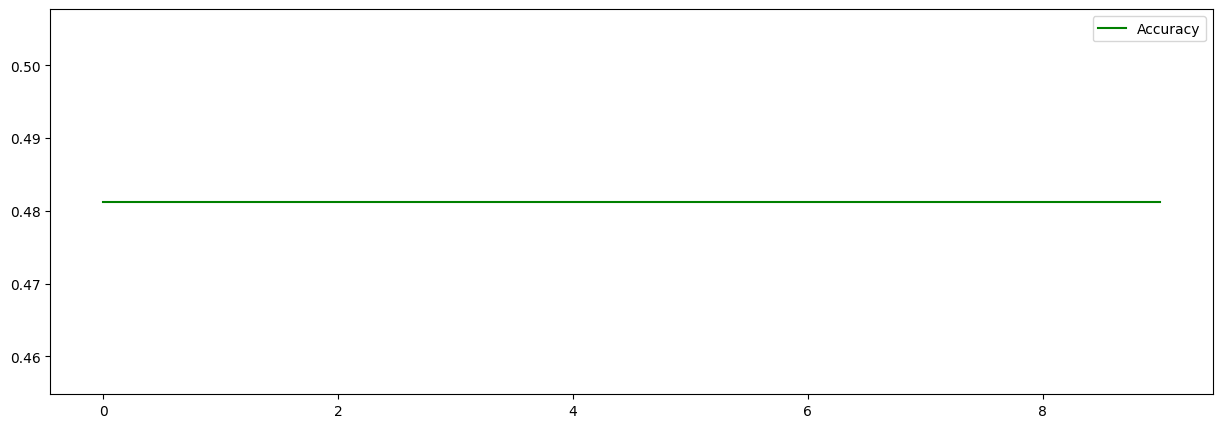

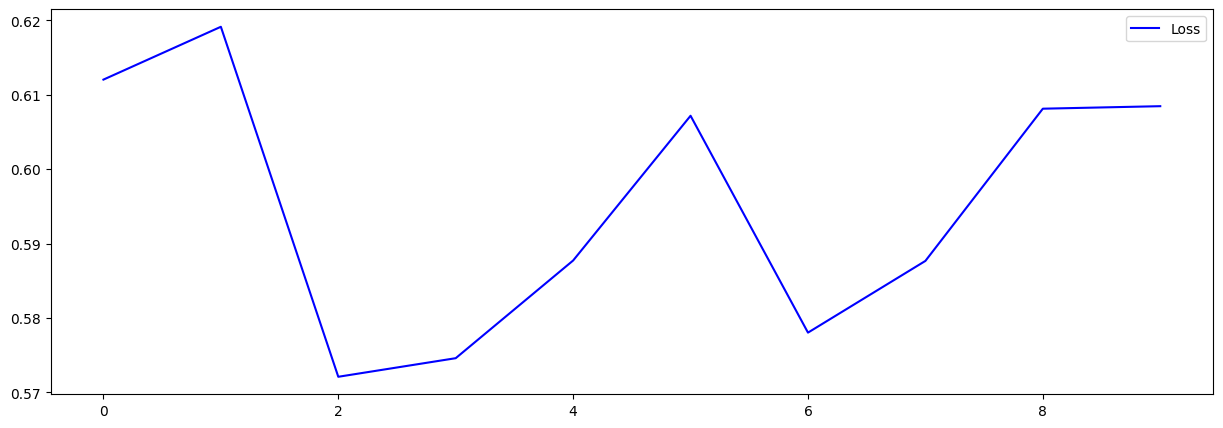

[0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104, 0.48124998807907104] 
 [0.6120501756668091, 0.6191529631614685, 0.5720958113670349, 0.5745950937271118, 0.5877291560173035, 0.6071902513504028, 0.5780326128005981, 0.5876739025115967, 0.6081392765045166, 0.6084767580032349]


In [453]:
lear = 0.001
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_3

In [454]:
lear = 0.0005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

Epoch : 1, train accuracy : 0.5013793706893921, train loss : 0.5565359592437744
Epoch : 1, val_accuracy : 0.48500001430511475, val_loss : 0.5718552470207214


Epoch : 2, train accuracy : 0.5024139285087585, train loss : 0.5648584365844727
Epoch : 2, val_accuracy : 0.48500001430511475, val_loss : 0.6230159401893616


Epoch : 3, train accuracy : 0.5012069940567017, train loss : 0.586582362651825
Epoch : 3, val_accuracy : 0.48500001430511475, val_loss : 0.562511146068573


Epoch : 4, train accuracy : 0.5022414922714233, train loss : 0.5644265413284302
Epoch : 4, val_accuracy : 0.48500001430511475, val_loss : 0.5886486172676086


Epoch : 5, train accuracy : 0.5017242431640625, train loss : 0.5480942130088806
Epoch : 5, val_accuracy : 0.48500001430511475, val_loss : 0.5556293725967407


Epoch : 6, train accuracy : 0.5018966794013977, train loss : 0.5393590927124023
Epoch : 6, val_accuracy : 0.48500001430511475, val_loss : 0.6496685743331909


Epoch : 7, train accuracy : 0.5024139285087585, 

# Train_loop_4

In [ ]:
lear = 0.0005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_5

In [ ]:
lear = 0.0005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_6

In [ ]:
lear = 0.005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_7

In [ ]:
lear = 0.005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train_loop_8


In [ ]:
lear = 0.005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)